## Training CNN on CIFAR10 Dataset

We begin with building a CNN architecture for image classification task on CIFAR10 dataset. In this first part of the tutorial, we will understand how to arrange the different architectural components of CNN network, defining the appropriate loss, training the network using backpropagation and finally testing it on the test data.

To make data loading simple, we would use the torchvision package created as part of PyTorch which has data loaders for standard datasets such as ImageNet, CIFAR10, MNIST and data transformers for XXX

### CIFAR10 dataset
![CIFAR10](images/cifar10.png)

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pdb

plt.ion()


transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='../../data/lab1/imgFolders', train=True,
                                        download=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='../../data/lab1/imgFolders', train=False,
                                       download=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        #self.conv1_bn =nn.BatchNorm2d(6)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        #self.is_training = False

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        #x = self.pool(F.relu(self.conv1_bn(self.conv1(x))))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        #x = F.dropout(x, p=0.2, training=self.is_training)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

plotIter = 2000
plotIterCntr = 0
numEpochs = 1
trainLoss = np.zeros((plotIter*numEpochs,1))
trainIter = np.arange(plotIter*numEpochs)
#plt.ion()

net.cuda()
#net.is_training = True

for epoch in range(numEpochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # wrap them in Variable
        inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.data[0]
        if i % plotIter == plotIter-1:    # print every plotIter mini-batches
            trainLoss[plotIterCntr] = running_loss / plotIter
            plotIterCntr+=1
            
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / plotIter))
            running_loss = 0.0
            
plt.plot(np.arange(plotIterCntr)*plotIter,trainLoss[0:plotIterCntr], label="train")
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

print('Finished Training')

In [ ]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [ ]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [ ]:
outputs = net(Variable(images).cuda())
_, predicted = torch.max(outputs.data, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j][0]]
                              for j in range(4)))

In [ ]:
## Prediction of accuracy
correct = 0
total = 0
import pdb

#net = net.cuda()

for data in testloader:
    images, labels = data
    outputs = net(Variable(images.cuda()))
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    #pdb.set_trace()
    labels = labels.cuda()
    correct += (predicted == labels).sum()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))


#### Visualization

In [ ]:
#### Visualization of Layer 1 weights
def plot_kernels(tensor, num_cols=6):
    if not tensor.ndim==4:
        raise Exception("assumes a 4D tensor")
    if not tensor.shape[-1]==3:
        raise Exception("last dim needs to be 3 to plot")
    num_kernels = tensor.shape[0]
    num_rows = 1+ num_kernels // num_cols
    fig = plt.figure(figsize=(num_cols,num_rows))
    for i in range(tensor.shape[0]):
        ax1 = fig.add_subplot(num_rows,num_cols,i+1)
        ax1.imshow(tensor[i])
        ax1.axis('off')
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])

    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()
    
net_cpu = net.cpu()
dat = net_cpu.conv1.weight.data.numpy()
maxVal = dat.max()
minVal = abs(dat.min())
maxVal = max(maxVal,minVal)
dat = dat / maxVal
dat = dat / 2
dat = dat + 0.5

plot_kernels(dat.transpose((0,2,3,1)))

#### Dropouts, Batch Normalization

In [4]:
import pdb 
class Net_DB(nn.Module):
    def __init__(self):
        super(Net_DB, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv1_bn = nn.BatchNorm2d(6)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        #self.is_training = False

    def forward(self, x):
        x = F.relu(self.conv1(x))
        #pdb.set_trace()
        x = self.pool(self.conv1_bn(x))
        #x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        #x = F.dropout(x, p=0.2, training=self.is_training)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net_db = Net_DB()

[1,  2000] loss: 2.019
[1,  4000] loss: 1.706
[1,  6000] loss: 1.597
[1,  8000] loss: 1.520
[1, 10000] loss: 1.452
[1, 12000] loss: 1.400


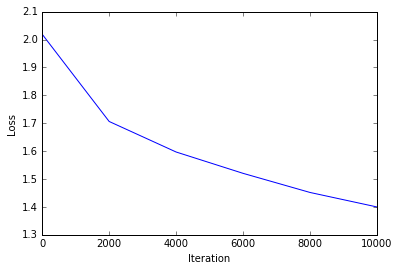

Finished Training


In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net_db.parameters(), lr=0.001, momentum=0.9)

plotIter = 2000
plotIterCntr = 0
numEpochs = 1
trainLoss = np.zeros((plotIter*numEpochs,1))
trainIter = np.arange(plotIter*numEpochs)

net_db.cuda()
#net_db.is_training = True

for epoch in range(numEpochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # wrap them in Variable
        inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net_db(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.data[0]
        if i % plotIter == plotIter-1:    # print every plotIter mini-batches
            trainLoss[plotIterCntr] = running_loss / plotIter
            plotIterCntr+=1
            
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / plotIter))
            running_loss = 0.0
            
plt.plot(np.arange(plotIterCntr)*plotIter,trainLoss[0:plotIterCntr], label="train")
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

print('Finished Training')

#net_db.is_training = False

In [ ]:
## Prediction of accuracy
correct = 0
total = 0

for data in testloader:
    images, labels = data
    outputs = net_db(Variable(images).cuda())
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    pdb.set_trace()
    correct += (predicted == labels).sum()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

#### Todo
Q. Train using exponential decay of learning rate.
Q. 